# Audience judgements of motion

Consider how participants moved during the concert and how these compare to their ratings of their own and each others (neighbours) movements during music listening.

1. Pull up the motion measurements and segment per piece (remote and hall?)
2. Pull up Questionnaire responses about how they moved
3. Check summary stats on movement behaviour relative to ratings per question
4. Rank motion by participants, can we see what a lot of movement looks like, vs a little?

In [1]:
import sys
import os
import time
import datetime as dt
import math
import numpy as np 
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.signal import butter,filtfilt
from scipy import interpolate
from scipy.interpolate import interp1d
import pingouin as pg

In [2]:
# NEW NO PD APPEND
def gap_nans(data,gap_t):
    # data is a pandas dataframe with columns called time and/or time_concert which is used to ID gaps greater than gap_T
    # gap_T is in milliseconds (ms)
    # rows of NaN data is added to non-time columns before the first sample, at edges of each gap, and after the last sample of data
    # these nans prevent interpolation errors through missing data
    cols = data.columns
    if 'time' in cols:
        time_col = 'time'
    if 'time_concert' in cols:
        time_col = 'time_concert'
        
    deltat = round(0.35*data[time_col].diff().median())
    dtdeltat =  pd.to_timedelta(deltat,unit = 'ms')
    dt = data[time_col].diff()    
    gapsi = np.array(dt[dt>gap_t].index)
    a = np.append(gapsi-1,dt.index[-1])
    gapsd = pd.DataFrame(index = a,columns = data.columns)
    for c in cols:
        if c.startswith('datetime'):
            gapsd[c] = data.loc[a,c]+dtdeltat
        if c.startswith('time'):
            gapsd[c] = data.loc[a,c]+deltat 

    a = np.append(gapsi,dt.index[0])
    gapsp = pd.DataFrame(index = a,columns = data.columns)
    for c in cols:
        if c.startswith('datetime'):
            gapsp[c] = data.loc[a,c]-dtdeltat
        if c.startswith('time'):
            gapsp[c] = data.loc[a,c]-deltat 

    data = pd.concat([gapsp,gapsd,data]).sort_values(time_col,ignore_index=True)
    return data

/Users/finn/.pyenv/versions/3.9.0/lib/python3.9/site-packages/outdated/utils.py:14: OutdatedCheckFailedWarning: Failed to check for latest version of package.
Set the environment variable OUTDATED_RAISE_EXCEPTION=1 for a full traceback.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(


In [3]:
general_loc = 'C:/Users/finnu/OneDrive - Universitetet i Oslo/Documents/Mobile_data/'

public_mlmotion = general_loc + 'Public/Motion_ML/'
public_ax3 = general_loc +  'Public/Motion_AX3/'
public_Part = general_loc + 'Public/Participants/'
public_time = general_loc + 'Public/Timing/'

In [3]:
general_loc = '../'

public_mlmotion = general_loc + 'Public_data/Motion_ML/'
public_ax3 = general_loc +  'Public_data/Motion_AX3/'
public_Part = general_loc + 'Public_data/Participants/'
public_time = general_loc + 'Public_data/Timing/'

In [4]:
concert_times = pd.read_csv(public_time +'Events_Main.csv',sep=",") #SV alignment for beeps
concert_times['Datetime']=(pd.to_datetime(concert_times['Datetime'])) # concert time stamps, confirm format

concert_times['sequence'] = concert_times.index
Main_concert_times = concert_times.set_index('Datetime')

In [5]:
# set the sampling period for the concert in UTC 
Start_time = pd.to_datetime('2021-10-26 17:30:00+0000').replace(tzinfo=None)
Synch_time = pd.to_datetime('2021-10-26 17:48:06+0000').replace(tzinfo=None)
Mid_time = pd.to_datetime('2021-10-26 19:00:00+0000').replace(tzinfo=None)
End_time = pd.to_datetime('2021-10-26 20:30:00+0000').replace(tzinfo=None)

# concert times 10 Hz
ts_ct = np.arange(-1086,9715, 0.1)*1000 
dt_ct = Synch_time + pd.to_timedelta(ts_ct,unit='ms')


concert_times = pd.read_csv(public_time +'Events_Full.csv',sep=",") #SV alignment for beeps
concert_times['Datetime']=(pd.to_datetime(concert_times['Datetime'])) # concert time stamps, confirm format
concert_times['sequence'] = concert_times.index
concert_times.set_index('Datetime',inplace = True)
#concert_times.iloc[50:75]

In [6]:
partDets = pd.read_csv(public_Part + 'Audience_Mapping_Public.csv')#,index_col = 0,header_col = 0)
# need only participants with aligned motion traces and questionnair responses
partDets = partDets.loc[partDets['Questionnaire_Language'].isin(['D','E']),:] # participants with at least some questionnaire responses
alignedParts = partDets.loc[partDets['Motion_Quality'].isin(['Q','R']),:].reset_index(drop = True) # with aligned motion measurements
aligned_Part_Codes = list(alignedParts.Participant_Code.values)
alignedParts

,Participant_Code,Participant_Number,Attendance,Questionnaire_Language,Motion_Quality,Link_Conflicts,Seat_Zone,Location,Longitude_Truncated,Lattitude_Truncated,Offset_1,Offset_2,Watch_Alone
0,ADQ001,1,A,D,Q,0,6.0,NaN,NaN,NaN,0.14,0.16,0.0
1,ADQ002,2,A,D,Q,0,3.0,NaN,NaN,NaN,NaN,-0.36,0.0
2,ADQ003,3,A,D,Q,0,2.0,NaN,NaN,NaN,0.88,1.02,0.0
3,ADQ004,4,A,D,Q,0,4.0,NaN,NaN,NaN,0.44,0.62,1.0
4,ADQ005,5,A,D,Q,0,4.0,NaN,NaN,NaN,0.04,0.12,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
107,BEQ115,115,B,E,Q,0,NaN,Porto,41.0,-9.0,-6.32,NaN,1.0
108,BEQ116,116,B,E,Q,0,NaN,Montréal,46.0,-74.0,-30.66,NaN,1.0
109,BEQ117,117,B,E,Q,0,NaN,Stockholm,59.0,17.0,-10.22,NaN,1.0
110,BEQ118,118,B,E,Q,0,NaN,Portola Valley California,37.0,-122.0,-28.00,NaN,0.0


In [178]:
tic = time.time()
# load those motion traces 
# gather the aligned recordings for the live performance. Combining AX3 and ML data!
aud_df = pd.DataFrame(index = ts_ct)
kept_dev = []
gap_t = 1000

for i,participant in alignedParts.iterrows():
    part = participant['Participant_Code']
    if part[2]=='Q': # Motionlab phone acc
        inst_d = pd.read_csv(public_mlmotion + part + '_Mobile_Motion.csv' )
    else: # AX3
        inst_d = pd.read_csv(public_ax3 + part + '_AX3_Motion.csv' )
    inst_d['datetime']=(pd.to_datetime(inst_d['datetime'])) # concert time stamps, confirm format
    datas = gap_nans(inst_d,1000)
    #get concert time
    resampled = pd.DataFrame(index = ts_ct)
    cols = datas.columns
    for col in cols[1:]:
        f = interpolate.interp1d(datas['time'], datas[col],fill_value='extrapolate')
        resampled[col] = f(ts_ct)
        
    # extract 1D accelerometer feature for easy comparison
    # and basic normalisation
    b = np.linalg.norm(resampled[['x','y','z']].diff().values,axis=1)
    
    if part[2]=='R': # aligned AX3 correction factor (basic but verified for low motion conditions)
        aud_df[part] = b.copy()*6 
    else:
        aud_df[part] = b.copy()
#     if np.nanmedian(b)>0:
#         aud_df[part] = b/np.nanmedian(b)
#     else:
#         aud_df[part] = b/np.nanmean(b)
        
aud_df.index = dt_ct
ori_aud_df = aud_df.copy()
ori_aud_df.index = (ts_ct/1000).round(1)

print(time.time()-tic)

97.79741287231445


Normalising with  first minute of every music piece. These are intevals in which participants were mostly still but also normalively moved. By taking the medium in these intervals (gathered across all performance) we get a standard close to the noise threshold with participants tendency to not move. 

Using specific segment of motion from begining (usually low motion) and across all pieces to reduce risk of favouring one piece over others. This is "normal" stillness.



In [25]:
NT=Main_concert_times.loc[Main_concert_times['Event_Type'].str.startswith('Music'),'Time_s']
NT

Datetime
2021-10-26 17:49:03      57.40
2021-10-26 17:56:02     476.08
2021-10-26 17:59:47     701.18
2021-10-26 18:07:36    1170.16
2021-10-26 18:22:20    2054.48
2021-10-26 18:28:25    2418.76
2021-10-26 18:34:01    2755.28
2021-10-26 19:16:00    5274.36
2021-10-26 19:32:37    6271.28
2021-10-26 19:41:02    6776.48
2021-10-26 19:44:17    6970.80
2021-10-26 19:48:29    7222.76
2021-10-26 19:54:13    7566.90
2021-10-26 19:58:51    7845.10
Name: Time_s, dtype: float64

In [13]:
Main_concert_times['Event_Type'].str.startswith('Music')

Datetime
2021-10-26 17:36:35    False
2021-10-26 17:36:53    False
2021-10-26 17:38:50    False
2021-10-26 17:38:56    False
2021-10-26 17:45:16    False
2021-10-26 17:47:02    False
2021-10-26 17:48:06    False
2021-10-26 17:48:20    False
2021-10-26 17:49:03     True
2021-10-26 17:56:02     True
2021-10-26 17:59:47     True
2021-10-26 18:07:36     True
2021-10-26 18:14:56    False
2021-10-26 18:15:28    False
2021-10-26 18:15:48    False
2021-10-26 18:21:19    False
2021-10-26 18:21:30    False
2021-10-26 18:22:20     True
2021-10-26 18:28:25     True
2021-10-26 18:34:01     True
2021-10-26 18:42:48    False
2021-10-26 18:43:51    False
2021-10-26 18:44:48    False
2021-10-26 19:09:27    False
2021-10-26 19:11:28    False
2021-10-26 19:11:46    False
2021-10-26 19:14:34    False
2021-10-26 19:14:53    False
2021-10-26 19:16:00     True
2021-10-26 19:28:25    False
2021-10-26 19:28:47    False
2021-10-26 19:29:07    False
2021-10-26 19:31:39    False
2021-10-26 19:32:37     True
2021-

In [ ]:
aud_df.loc[NT.index[i]+10:NT.index[i]+100]

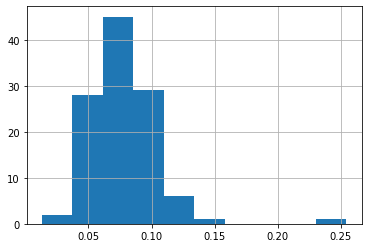

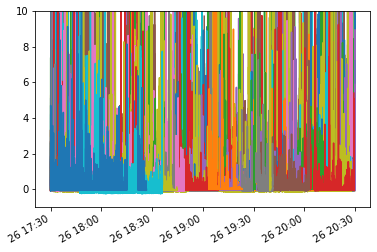

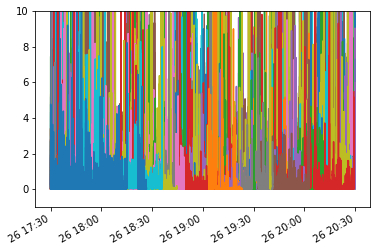

In [30]:
NT = Main_concert_times.loc[Main_concert_times['Event_Type'].str.startswith('Music'),'Event_Duration']

Scale_move = pd.DataFrame()
for i in range(len(NT)):
    Scale_move = pd.concat([Scale_move,aud_df.loc[NT.index[i]+pd.to_timedelta(10,unit='s'):NT.index[i]+pd.to_timedelta(100,unit='s')]],axis=0)

Scale_move.median().hist()
matched_median = Scale_move.median().median()
meds = Scale_move.median()

alt_aud_df = aud_df.copy()
# # scale proportional
# for c in alt_aud_df.columns:
#     alt_aud_df[c] = matched_median*aud_df[c]/meds[c]
    
# scale linear
for c in alt_aud_df.columns:
    alt_aud_df[c] = aud_df[c]-meds[c]
    
alt_aud_df.plot(legend = False)
plt.ylim([-1,10])
plt.show()
aud_df.plot(legend = False)
plt.ylim([-1,10])
plt.show()

<AxesSubplot:>

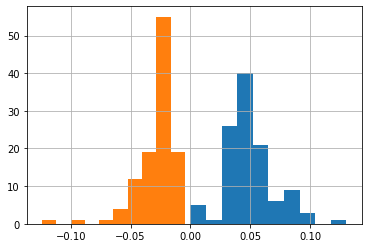

In [33]:
# normalisatin test
ax = aud_df.quantile(0.25).hist()
alt_aud_df.quantile(0.25).hist(ax=ax)

In [34]:
Near_Rels = pd.read_csv(public_Part + 'Near_Participants_Hall.csv')

# reduce to list of relationships included in the dataset available here
Sub_Rels = Near_Rels.loc[Near_Rels['Participant_Code_1'].isin(aligned_Part_Codes),:]
Sub_Rels = Sub_Rels.loc[Sub_Rels['Participant_Code_2'].isin(aligned_Part_Codes),:].reset_index(drop = True)

## Normalisation for motion measurements

We really need to bring the motion measurements into a similar range of values that are comparable over time and between participants.

In theory, there are a few contributors of signal value changes in these measurements:

1. Sensor noise: dependent on the measurement device, so the amplitude will differ between participants, but this is the small jitter in values that is present across all movement conditions. This should be noticiable in differences from sample to sample, so at the initial near 60 Hz rate. We want to reduce this to nothing if possible.

2. Small displacement: Movements at a slower rate than sensor noise, trajectories in 250-10000 ms with mostly small amplitudes, often involuntary, at least during passive music listening. This need to be brought into a comparable range between participants, but not necessarily matched in distribution. Maybe match at lower range and check that scale isn't off the charts different (factor of 10). 

3. Clapping: 4-2 Hz oscillation for sustained period, 2-80 seconds, with some variation in intensity (amplitude). Participants movement recordings can be scaled to the range of common values. Everyone should have calm claps, some may have more time in the extremely excited range, so normalised by 25th percentile? 

4. Big displacement: One off displacements at rate of one or twice every 2-30 minutes. These are changes in seating or posture that are triggers for behaviour change and rare during music listening but common before and after performances. Not garaunteed in all movement recordings. Nor is it certain they should be matched between participants, but can be a check on scale.

So, ideas about making things work: look at cummulative distributions of first order differences with different sample rates
    50 Hz, 10 Hz, 1 Hz, 0.1 Hz. 
    
Test on pairs of recordings to bring parameters into focus: noise suppression, range alignment, truncation on extremes.

In [36]:
def stats_ts(df):
    # Frequency
    stats_df = df \
    .groupby('value') \
    ['value'] \
    .agg('count') \
    .pipe(pd.DataFrame) \
    .rename(columns = {'value': 'frequency'})

    # PDF
    stats_df['pdf'] = stats_df['frequency'] / sum(stats_df['frequency'])
    # CDF
    stats_df['cdf'] = stats_df['pdf'].cumsum()
    stats_df = stats_df.reset_index()
    
    return stats_df

In [37]:
NT = Main_concert_times.loc[Main_concert_times['Event_Type'].str.startswith('Music'),'Event_Duration']

Scale_move = pd.DataFrame()
for i in range(len(NT)):
    Scale_move = pd.concat([Scale_move,aud_df.loc[NT.index[i]:NT.index[i]+pd.to_timedelta(60,unit='s')]],axis=0)

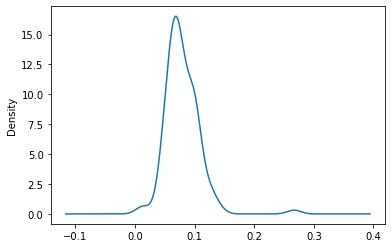

In [38]:
#Scale_move.median().hist()
Scale_move.median().plot.kde()

matched_median = Scale_move.median().median()
meds = Scale_move.median()

In [80]:
Scale_moved = Scale_move.copy()
for c in Scale_moved.columns:
    Scale_moved.loc[:,c] = matched_median*Scale_move[c]/meds[c]

C:\Users\finnu\AppData\Local\Temp\ipykernel_12964\2234204641.py:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  cdfs_df[c] = f(x_cdf)
C:\Users\finnu\AppData\Local\Temp\ipykernel_12964\2234204641.py:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  cdfs_df[c] = f(x_cdf)
C:\Users\finnu\AppData\Local\Temp\ipykernel_12964\2234204641.py:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.c

(0.0, 0.5)

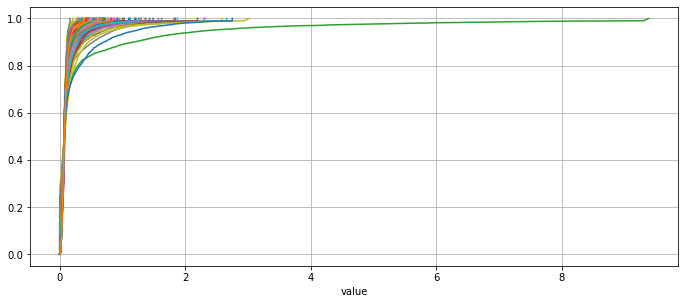

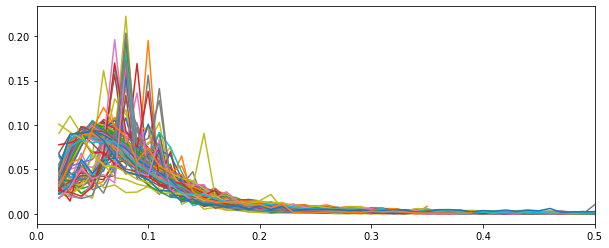

In [123]:
fig = plt.figure(figsize=[10,4])
ax = fig.add_axes([0.1, 0.1, 0.9, 0.9])
x_cdf = np.arange(0.01,5,0.01)
s = pd.Series(Scale_moved.iloc[:,1], name = 'value')
df = pd.DataFrame(s)
cdfs_df = pd.DataFrame(index =x_cdf)
stats_df = stats_ts(df)
f = interpolate.interp1d(stats_df['cdf'], stats_df['value'],fill_value='extrapolate')

for c in Scale_moved.columns:
    s = pd.Series(Scale_moved[c], name = 'value')
    df = pd.DataFrame(s)
    thr = df['value'].quantile(q=.99)
    df.loc[df['value']>thr,'value']= thr
    stats_df = stats_ts(df)
    f = interpolate.interp1d(stats_df['value'], stats_df['cdf'],bounds_error=False)
    cdfs_df[c] = f(x_cdf)
    
    # Plot
    stats_df.plot(x = 'value', y = 'cdf',label = c, grid = True,ax=ax,legend = False)
    
cdfs_df.diff().plot(legend=False,figsize=[10,4])
plt.xlim([0,0.5])

C:\Users\finnu\AppData\Local\Temp\ipykernel_12964\2550303591.py:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  cdfs_df[c] = f(x_cdf)
C:\Users\finnu\AppData\Local\Temp\ipykernel_12964\2550303591.py:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  cdfs_df[c] = f(x_cdf)
C:\Users\finnu\AppData\Local\Temp\ipykernel_12964\2550303591.py:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.c

(0.0, 0.5)

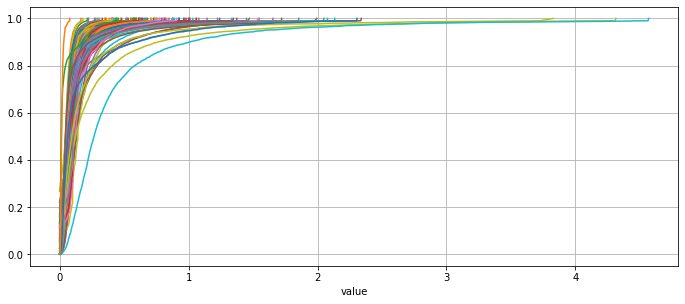

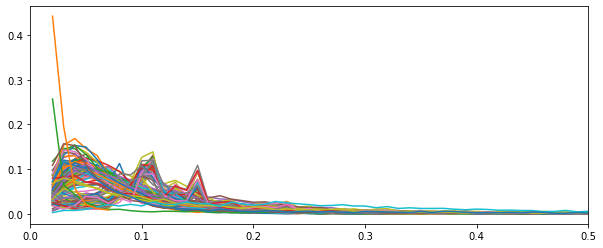

In [124]:
fig = plt.figure(figsize=[10,4])
ax = fig.add_axes([0.1, 0.1, 0.9, 0.9])
x_cdf = np.arange(0.01,5,0.01)
s = pd.Series(Scale_move.iloc[:,1], name = 'value')
df = pd.DataFrame(s)
cdfs_df = pd.DataFrame(index =x_cdf)
stats_df = stats_ts(df)
f = interpolate.interp1d(stats_df['cdf'], stats_df['value'],fill_value='extrapolate')

for c in Scale_move.columns:
    s = pd.Series(Scale_move[c], name = 'value')
    df = pd.DataFrame(s)
    thr = df['value'].quantile(q=.99)
    df.loc[df['value']>thr,'value']= thr
    stats_df = stats_ts(df)
    f = interpolate.interp1d(stats_df['value'], stats_df['cdf'],bounds_error=False)
    cdfs_df[c] = f(x_cdf)
    
    # Plot
    stats_df.plot(x = 'value', y = 'cdf',label = c, grid = True,ax=ax,legend = False)
    
cdfs_df.diff().plot(legend=False,figsize=[10,4])
plt.xlim([0,0.5])

C:\Users\finnu\AppData\Local\Temp\ipykernel_12964\1578668856.py:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  cdfs_df[c] = f(x_cdf)
C:\Users\finnu\AppData\Local\Temp\ipykernel_12964\1578668856.py:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  cdfs_df[c] = f(x_cdf)
C:\Users\finnu\AppData\Local\Temp\ipykernel_12964\1578668856.py:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.c

(0.0, 0.5)

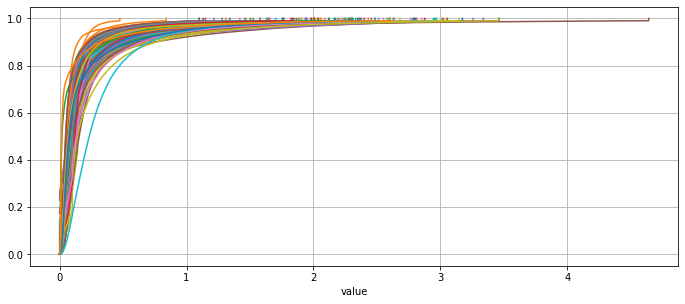

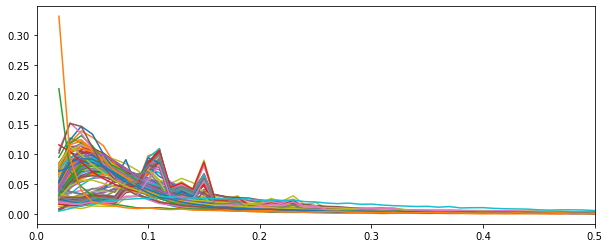

In [125]:
fig = plt.figure(figsize=[10,4])
ax = fig.add_axes([0.1, 0.1, 0.9, 0.9])
x_cdf = np.arange(0.01,5,0.01)
s = pd.Series(aud_df.iloc[:,1], name = 'value')
df = pd.DataFrame(s)
cdfs_df = pd.DataFrame(index =x_cdf)
stats_df = stats_ts(df)
f = interpolate.interp1d(stats_df['cdf'], stats_df['value'],fill_value='extrapolate')
for c in aud_df.columns:
    s = pd.Series(aud_df[c], name = 'value')
    df = pd.DataFrame(s)
    thr = df['value'].quantile(q=.99)
    df.loc[df['value']>thr,'value']= thr
    stats_df = stats_ts(df)
    f = interpolate.interp1d(stats_df['value'], stats_df['cdf'],bounds_error=False)
    cdfs_df[c] = f(x_cdf)
    stats_df.plot(x = 'value', y = 'cdf',label = c, grid = True,ax=ax,legend = False)
cdfs_df.diff().plot(legend=False,figsize=[10,4])
plt.xlim([0,0.5])

C:\Users\finnu\AppData\Local\Temp\ipykernel_12964\3488049862.py:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  cdfs_df[c] = f(x_cdf)
C:\Users\finnu\AppData\Local\Temp\ipykernel_12964\3488049862.py:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  cdfs_df[c] = f(x_cdf)
C:\Users\finnu\AppData\Local\Temp\ipykernel_12964\3488049862.py:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.c

(0.0, 0.5)

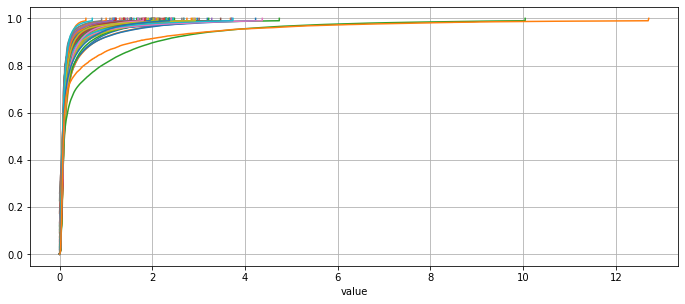

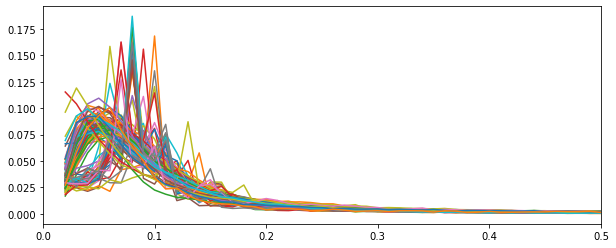

In [126]:
fig = plt.figure(figsize=[10,4])
ax = fig.add_axes([0.1, 0.1, 0.9, 0.9])
x_cdf = np.arange(0.01,5,0.01)
s = pd.Series(alt_aud_df.iloc[:,1], name = 'value')
df = pd.DataFrame(s)
cdfs_df = pd.DataFrame(index =x_cdf)
stats_df = stats_ts(df)
f = interpolate.interp1d(stats_df['cdf'], stats_df['value'],fill_value='extrapolate')
for c in aud_df.columns:
    s = pd.Series(alt_aud_df[c], name = 'value')
    df = pd.DataFrame(s)
    thr = df['value'].quantile(q=.99)
    df.loc[df['value']>thr,'value']= thr
    stats_df = stats_ts(df)
    f = interpolate.interp1d(stats_df['value'], stats_df['cdf'],bounds_error=False)
    cdfs_df[c] = f(x_cdf)
    stats_df.plot(x = 'value', y = 'cdf',label = c, grid = True,ax=ax,legend = False)
cdfs_df.diff().plot(legend=False,figsize=[10,4])
plt.xlim([0,0.5])

In [ ]:
#norm test for aud_df


here we have at least three different patterns of behaviour
those that have mostly zeros
those that have a noise peak around 0.02
those that have a noise peak around 0.1, but sharply (might be the Androids with the sharp presision limit)

might also want to describe the gradual peaks around 0.1  

we can assume these are the noise characteristics that would be worth flattening away 

what happens if we cut noise at twice peak? 
Thresh is min([2*(resampled pdf),quantile(q=0.75)])

<AxesSubplot:>

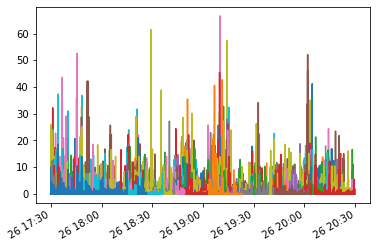

In [371]:
# 2*cdfs_df.diff().idxmax()
# mus_cat.quantile(q=0.6)
alt_aud_df = aud_df.copy()
for c in alt_aud_df.columns:
    thr = min([2*cdfs_df[c].diff().idxmax(),mus_cat[c].quantile(q=0.6)])
    alt_aud_df[c] =  alt_aud_df[c] - thr
    alt_aud_df.loc[alt_aud_df[c]<0,c] = np.nan
alt_aud_df.plot(legend = False)

In [127]:
partDets.loc[partDets['Attendance'].isin(['A']),'Participant_Code'].values

array(['ADQ001', 'ADQ002', 'ADQ003', 'ADQ004', 'ADQ005', 'ADQ006',
       'ADQ007', 'ADQ008', 'ADQ009', 'ADQ010', 'ADQ011', 'ADQ012',
       'ADQ013', 'ADQ014', 'ADQ015', 'ADQ016', 'ADQ017', 'ADQ018',
       'ADQ019', 'ADQ020', 'ADQ021', 'ADQ022', 'ADQ023', 'ADQ024',
       'ADQ025', 'ADQ026', 'ADQ027', 'ADQ028', 'ADQ029', 'ADQ030',
       'ADQ031', 'ADQ032', 'ADQ033', 'ADQ034', 'ADQ035', 'ADQ036',
       'ADQ037', 'ADQ038', 'ADQ039', 'ADQ040', 'ADQ041', 'ADQ042',
       'ADQ043', 'ADQ044', 'ADQ045', 'ADQ046', 'ADQ047', 'ADQ048',
       'ADQ049', 'ADQ050', 'ADQ051', 'ADQ052', 'ADQ053', 'ADQ054',
       'ADQ055', 'ADQ056', 'ADQ057', 'ADQ058', 'ADQ059', 'ADQ060',
       'ADQ061', 'ADQ062', 'ADQ063', 'ADQ064', 'ADQ065', 'ADQ066',
       'ADR067', 'ADR068', 'ADR069', 'ADR070', 'ADR071', 'ADS072',
       'ADS073', 'ADS074', 'ADT075', 'ADU076', 'AEQ077', 'AEQ078',
       'AEQ079', 'AEQ080', 'AEQ081', 'AEQ082', 'AEQ083', 'AEQ084',
       'AEQ085', 'AEQ086', 'AEQ087', 'AEQ088', 'AEQ089', 'AER0

array([ 1.        ,  0.52652897,  1.99607619,  7.75683255, 14.45870767])

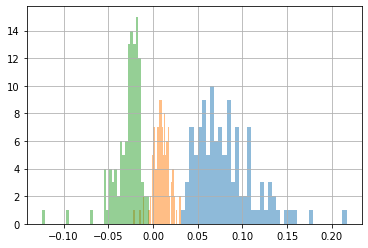

In [39]:
# array([ 1.        ,  1.5550507 ,  2.56791346, 10.57168739])
# array([ 1.        ,  0.82818318,  5.54803117, 24.12875715, 46.39970122])

# ax = alt_aud_df.quantile(0.95).hist(bins=20,alpha=0.5)
# alt_aud_df.quantile(0.9).hist(bins=20,alpha=0.5)
ax = alt_aud_df.quantile(0.75).hist(bins=40,alpha=0.5)

alt_aud_df.quantile(0.5).hist(bins=40,alpha=0.5,ax=ax)
alt_aud_df.quantile(0.25).hist(bins=40,alpha=0.5,ax=ax)
np.array([alt_aud_df.quantile(0.25).std(),alt_aud_df.quantile(0.5).std(),alt_aud_df.quantile(0.75).std(),alt_aud_df.quantile(0.9).std(),alt_aud_df.quantile(0.95).std()])/alt_aud_df.quantile(0.25).std()

array([ 1.        ,  0.52652897,  1.99607619,  7.75683255, 14.45870767])

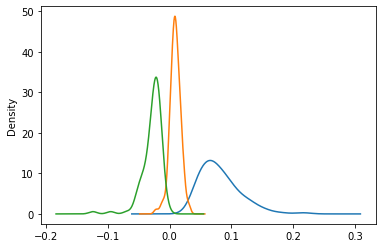

In [40]:
# array([ 1.        ,  1.5550507 ,  2.56791346, 10.57168739])
# array([ 1.        ,  0.82818318,  5.54803117, 24.12875715, 46.39970122])

# ax = alt_aud_df.quantile(0.95).hist(bins=20,alpha=0.5)
# alt_aud_df.quantile(0.9).hist(bins=20,alpha=0.5)
ax = alt_aud_df.quantile(0.75).plot.kde()
alt_aud_df.quantile(0.5).plot.kde()
alt_aud_df.quantile(0.25).plot.kde()
np.array([alt_aud_df.quantile(0.25).std(),alt_aud_df.quantile(0.5).std(),alt_aud_df.quantile(0.75).std(),alt_aud_df.quantile(0.9).std(),alt_aud_df.quantile(0.95).std()])/alt_aud_df.quantile(0.25).std()

array([ 1.        ,  1.38131172,  2.54087101,  6.72760545, 11.85834897])

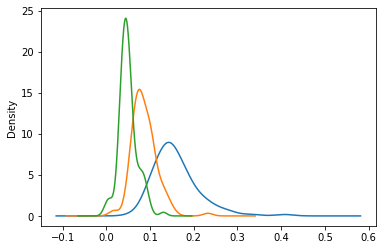

In [41]:
# original values
# ax = aud_df.quantile(0.95).hist(bins=20,alpha=0.5)
# aud_df.quantile(0.9).hist(bins=20,alpha=0.5,ax=ax)
ax = aud_df.quantile(0.75).plot.kde()
aud_df.quantile(0.5).plot.kde()
aud_df.quantile(0.25).plot.kde()
np.array([aud_df.quantile(0.25).std(),aud_df.quantile(0.5).std(),aud_df.quantile(0.75).std(),aud_df.quantile(0.9).std(),aud_df.quantile(0.95).std()])/aud_df.quantile(0.25).std()

array([ 1.        ,  0.52652897,  1.99607619,  7.75683255, 14.45870767])

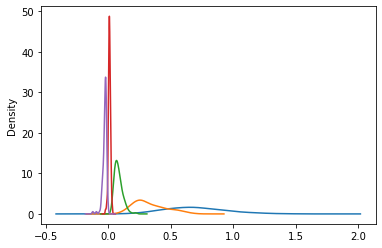

In [42]:
#array([ 1.        ,  1.49668896,  2.41030266,  6.03935999, 11.37886374])
# median on claps *10 thresh for in hall, quantile (0.85)*12 for remote
ax = alt_aud_df.quantile(0.95).plot.kde()
alt_aud_df.quantile(0.9).plot.kde()
alt_aud_df.quantile(0.75).plot.kde()
alt_aud_df.quantile(0.5).plot.kde()
alt_aud_df.quantile(0.25).plot.kde()
np.array([alt_aud_df.quantile(0.25).std(),alt_aud_df.quantile(0.5).std(),alt_aud_df.quantile(0.75).std(),alt_aud_df.quantile(0.9).std(),alt_aud_df.quantile(0.95).std()])/alt_aud_df.quantile(0.25).std()

[Timestamp('2021-10-26 17:36:35'), Timestamp('2021-10-26 18:14:55')]


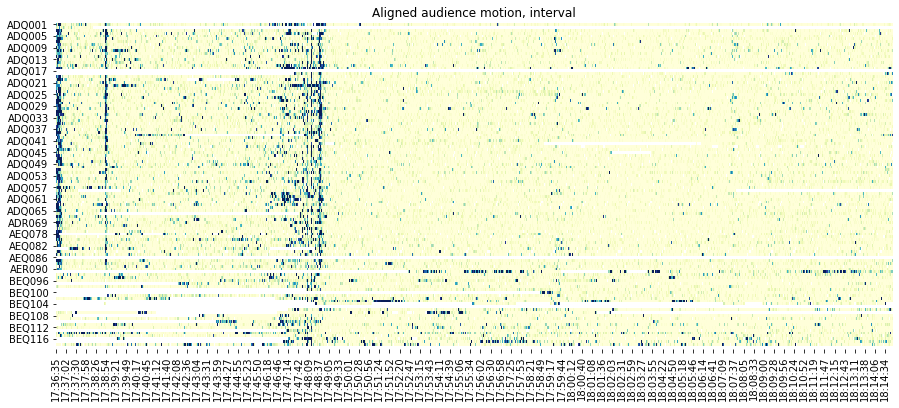

In [44]:
# # now evaluate 
seg_start = concert_times.iloc[0,:].name #concert_times[concert_times['events'].str.contains('Beethoven 1')].index
seg_end = concert_times.iloc[60,:].name
print([seg_start,seg_end])

seg_df = alt_aud_df.loc[seg_start:seg_end]
#seg_df = seg_df.loc[:,seg_df.sum()>0]
#seg_df = seg_df.fillna(0)

fig, (ax1) = plt.subplots(1, 1,figsize = [15,6])
#sns.color_palette("flare", as_cmap=True)
#sns.color_palette("YlOrBr", as_cmap=True)
chart = sns.heatmap(data=seg_df.transpose(), ax=ax1,vmin=0, vmax=1,cbar=False, cmap="YlGnBu")

ax1.set_xticklabels(seg_df.iloc[ax1.get_xticks()].index.strftime("%H:%M:%S"))
ax1.set_title('Aligned audience motion, interval')
#plt.savefig('./Plots/Realigned_Hall_segment.png',dpi = 300)
plt.show()

[Timestamp('2021-10-26 17:36:35'), Timestamp('2021-10-26 17:43:24')]


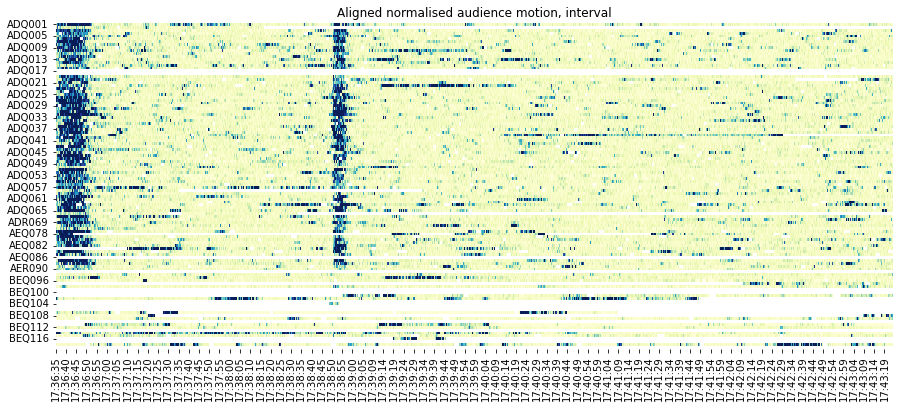

In [138]:
# now evaluate 
seg_start = concert_times.iloc[0,:].name #concert_times[concert_times['events'].str.contains('Beethoven 1')].index
seg_end = concert_times.iloc[15,:].name
print([seg_start,seg_end])

seg_df = alt_aud_df.loc[seg_start:seg_end]

fig, (ax1) = plt.subplots(1, 1,figsize = [15,6])
chart = sns.heatmap(data=seg_df.transpose(), ax=ax1,vmin=0, vmax=1,cbar=False, cmap="YlGnBu")

ax1.set_xticklabels(seg_df.iloc[ax1.get_xticks()].index.strftime("%H:%M:%S"))
ax1.set_title('Aligned normalised audience motion, interval')
#plt.savefig('./Plots/Realigned_Hall_segment.png',dpi = 300)
plt.show()

[Timestamp('2021-10-26 17:36:35'), Timestamp('2021-10-26 17:43:24')]


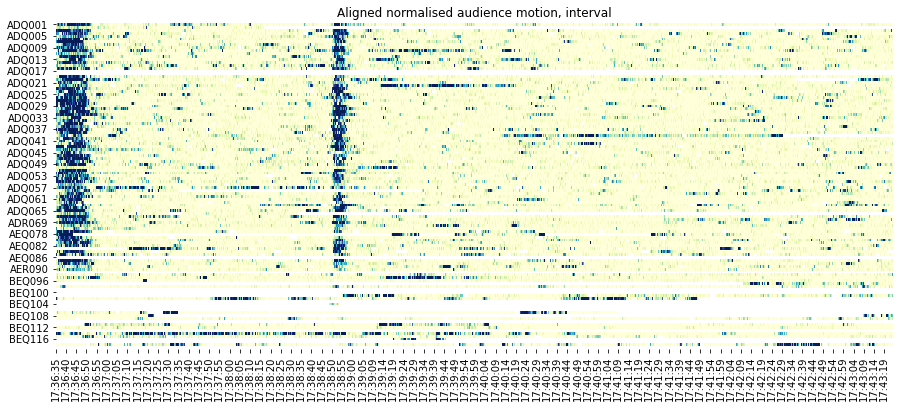

In [47]:
# now evaluate 
seg_start = concert_times.iloc[0,:].name #concert_times[concert_times['events'].str.contains('Beethoven 1')].index
seg_end = concert_times.iloc[15,:].name
print([seg_start,seg_end])

seg_df = alt_aud_df.loc[seg_start:seg_end]

fig, (ax1) = plt.subplots(1, 1,figsize = [15,6])
chart = sns.heatmap(data=seg_df.transpose(), ax=ax1,vmin=0, vmax=1,cbar=False, cmap="YlGnBu")

ax1.set_xticklabels(seg_df.iloc[ax1.get_xticks()].index.strftime("%H:%M:%S"))
ax1.set_title('Aligned normalised audience motion, interval')
#plt.savefig('./Plots/Realigned_Hall_segment.png',dpi = 300)
plt.show()

[Timestamp('2021-10-26 17:36:35'), Timestamp('2021-10-26 17:43:24')]


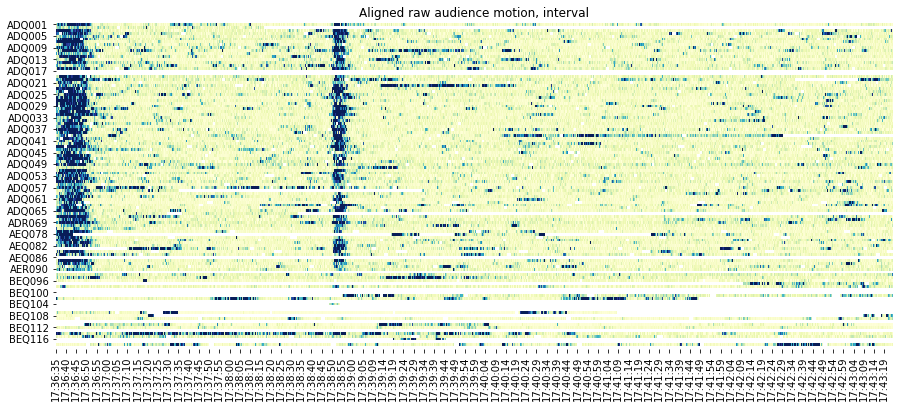

In [48]:
# now evaluate 
# original units
seg_start = concert_times.iloc[0,:].name #concert_times[concert_times['events'].str.contains('Beethoven 1')].index
seg_end = concert_times.iloc[15,:].name
print([seg_start,seg_end])

seg_df = aud_df.loc[seg_start:seg_end]

fig, (ax1) = plt.subplots(1, 1,figsize = [15,6])
chart = sns.heatmap(data=seg_df.transpose(), ax=ax1,vmin=0, vmax=1,cbar=False, cmap="YlGnBu")

ax1.set_xticklabels(seg_df.iloc[ax1.get_xticks()].index.strftime("%H:%M:%S"))
ax1.set_title('Aligned raw audience motion, interval')
#plt.savefig('./Plots/Realigned_Hall_segment.png',dpi = 300)
plt.show()

### Consider normalising before quantity of motion at 10 Hz 

The distinction of noise and signal is may be easier to extract from original accelerometer values. QoM folds together noise in a way that can obfuscate.

In [13]:
# concert times 50 Hz
ts_ct = np.arange(-1086,9715, 0.02)*1000
dt_ct = Synch_time + pd.to_timedelta(ts_ct,unit='ms')

<AxesSubplot:>

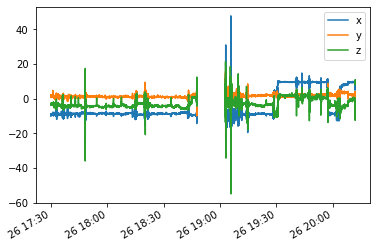

In [14]:
part = alignedParts.loc[6,'Participant_Code']
if part[2]=='Q': # Motionlab phone acc
    inst_d = pd.read_csv(public_mlmotion + part + '_Mobile_Motion.csv' )
    C = 1
else: # AX3
    inst_d = pd.read_csv(public_ax3 + part + '_AX3_Motion.csv' )
    C = 8
inst_d['datetime']=(pd.to_datetime(inst_d['datetime'])) # concert time stamps, confirm format
datas = gap_nans(inst_d,gap_t)
#get concert time
resampled = pd.DataFrame(index = ts_ct)
cols = datas.columns
for col in cols[1:]:
    f = interpolate.interp1d(datas['time'], datas[col],fill_value='extrapolate')
    resampled[col] = f(ts_ct)

# extract 1D accelerometer feature for easy comparison
# and basic normalisation
# b = np.linalg.norm(resampled[['x','y','z']].diff().values,axis=1)
resampled.index = dt_ct

resampled.loc[:,['x','y','z']].plot()

(0.0, 1.0)

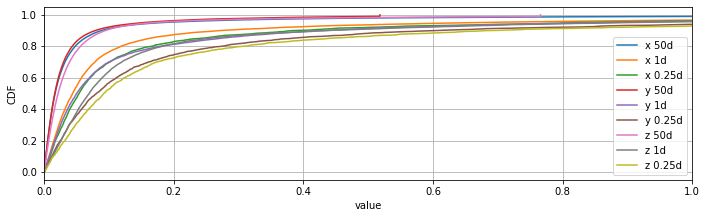

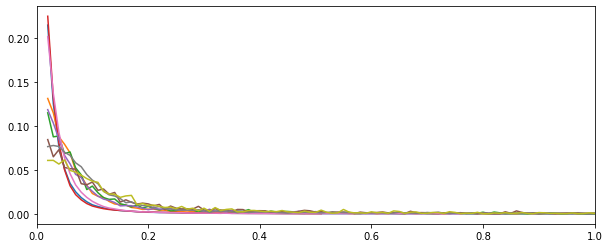

In [15]:
fig = plt.figure(figsize=[10,6])
ax1 = fig.add_axes([0.1, 0.1, 0.9, 0.4])
# ax2 = fig.add_axes([0.1, 0.6, 0.9, 0.4])
x_cdf = np.arange(0.01,5,0.01)
cdfs_df = pd.DataFrame(index =x_cdf)

for c in ['x','y','z']:#resampled.columns:
    s = pd.Series(resampled[c].diff().abs(), name = 'value')
    df = pd.DataFrame(s)
    thr = df['value'].quantile(q=.99)
    df.loc[df['value']>thr,'value']= thr

    # Frequency
    stats_df = stats_ts(df)
    f = interpolate.interp1d(stats_df['value'], stats_df['cdf'],bounds_error=False)
    cdfs_df[c+' 50d'] = f(x_cdf)
    # Plot
    stats_df.plot(x = 'value', y = 'cdf',label = c+' 50d', grid = True,ax=ax1)
    ax1.set_ylabel('CDF')
    
    s = pd.Series(resampled[c].iloc[np.arange(1,len(resampled),50)].diff().abs(), name = 'value')
    df = pd.DataFrame(s)
    thr = df['value'].quantile(q=.99)
    df.loc[df['value']>thr,'value']= thr

    stats_df = stats_ts(df)
    f = interpolate.interp1d(stats_df['value'], stats_df['cdf'],bounds_error=False)
    cdfs_df[c+ ' 1d'] = f(x_cdf)
    # Plot
    stats_df.plot(x = 'value', y = 'cdf',label = c+ ' 1d', grid = True,ax=ax1)
    ax1.set_xlim([0,1])
    
    s = pd.Series(resampled[c].iloc[np.arange(1,len(resampled),200)].diff().abs(), name = 'value')
    df = pd.DataFrame(s)
    thr = df['value'].quantile(q=.99)
    df.loc[df['value']>thr,'value']= thr

    stats_df = stats_ts(df)
    f = interpolate.interp1d(stats_df['value'], stats_df['cdf'],bounds_error=False)
    cdfs_df[c+ ' 0.25d'] = f(x_cdf)
    # Plot
    stats_df.plot(x = 'value', y = 'cdf',label = c+ ' 0.25d', grid = True,ax=ax1)
    ax1.set_xlim([0,1])

cdfs_df.diff().plot(legend=False,figsize=[10,4])
plt.xlim([0,1])

(0.0, 1.0)

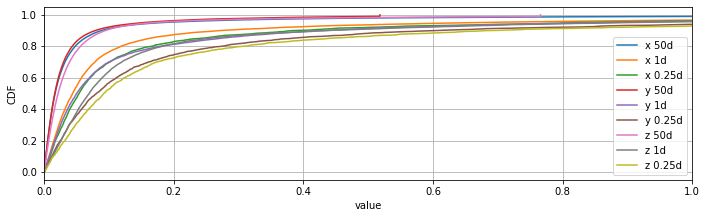

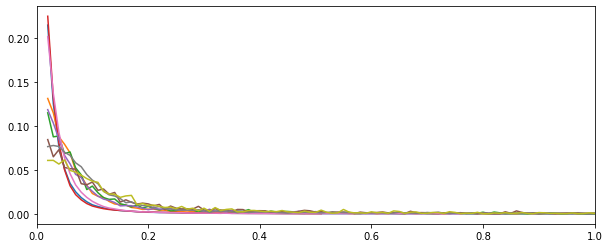

In [16]:
fig = plt.figure(figsize=[10,6])
ax1 = fig.add_axes([0.1, 0.1, 0.9, 0.4])
# ax2 = fig.add_axes([0.1, 0.6, 0.9, 0.4])
x_cdf = np.arange(0.01,5,0.01)
cdfs_df = pd.DataFrame(index =x_cdf)

for c in ['x','y','z']:#resampled.columns:
    s = pd.Series(resampled[c].diff().abs(), name = 'value')
    df = pd.DataFrame(s)
    thr = df['value'].quantile(q=.99)
    df.loc[df['value']>thr,'value']= thr

    # Frequency
    stats_df = stats_ts(df)
    f = interpolate.interp1d(stats_df['value'], stats_df['cdf'],bounds_error=False)
    cdfs_df[c+' 50d'] = f(x_cdf)
    # Plot
    stats_df.plot(x = 'value', y = 'cdf',label = c+' 50d', grid = True,ax=ax1)
    ax1.set_ylabel('CDF')
    
    s = pd.Series(resampled[c].iloc[np.arange(1,len(resampled),50)].diff().abs(), name = 'value')
    df = pd.DataFrame(s)
    thr = df['value'].quantile(q=.99)
    df.loc[df['value']>thr,'value']= thr

    stats_df = stats_ts(df)
    f = interpolate.interp1d(stats_df['value'], stats_df['cdf'],bounds_error=False)
    cdfs_df[c+ ' 1d'] = f(x_cdf)
    # Plot
    stats_df.plot(x = 'value', y = 'cdf',label = c+ ' 1d', grid = True,ax=ax1)
    ax1.set_xlim([0,1])
    
    s = pd.Series(resampled[c].iloc[np.arange(1,len(resampled),200)].diff().abs(), name = 'value')
    df = pd.DataFrame(s)
    thr = df['value'].quantile(q=.99)
    df.loc[df['value']>thr,'value']= thr

    stats_df = stats_ts(df)
    f = interpolate.interp1d(stats_df['value'], stats_df['cdf'],bounds_error=False)
    cdfs_df[c+ ' 0.25d'] = f(x_cdf)
    # Plot
    stats_df.plot(x = 'value', y = 'cdf',label = c+ ' 0.25d', grid = True,ax=ax1)
    ax1.set_xlim([0,1])

cdfs_df.diff().plot(legend=False,figsize=[10,4])
plt.xlim([0,1])

<AxesSubplot:>

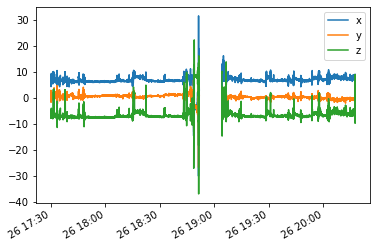

In [17]:
part = alignedParts.loc[8,'Participant_Code']
if part[2]=='Q': # Motionlab phone acc
    inst_d = pd.read_csv(public_mlmotion + part + '_Mobile_Motion.csv' )
else: # AX3
    inst_d = pd.read_csv(public_ax3 + part + '_AX3_Motion.csv' )
inst_d['datetime']=(pd.to_datetime(inst_d['datetime'])) # concert time stamps, confirm format
datas = gap_nans(inst_d,gap_t)
#get concert time
resampled = pd.DataFrame(index = ts_ct)
cols = datas.columns
for col in cols[1:]:
    f = interpolate.interp1d(datas['time'], datas[col],fill_value='extrapolate')
    resampled[col] = f(ts_ct)
    
    

# extract 1D accelerometer feature for easy comparison
# and basic normalisation
# b = np.linalg.norm(resampled[['x','y','z']].diff().values,axis=1)
resampled.index = dt_ct

resampled.loc[:,['x','y','z']].plot()

## segmentation of motion recordings to music intervals content

In [49]:
# switch in perfered normalisation 
aud_df = alt_aud_df.copy()

In [ ]:
# defined Events_Main_Extra_Tags to have a set of demarked events to 

In [58]:
concert_times = pd.read_csv(public_time +'Events_Main_extra_Tags.csv',sep=",") #SV alignment for beeps
concert_times['Datetime']=(pd.to_datetime(concert_times['Datetime'])) # concert time stamps, confirm format

concert_times['sequence'] = concert_times.index
Main_concert_times = concert_times.set_index('Datetime')

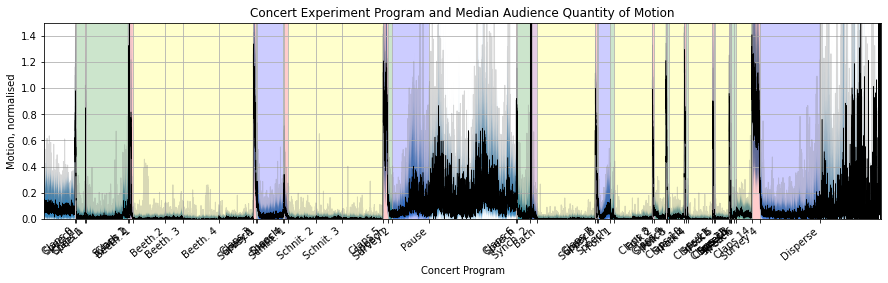

In [59]:
yrange = [0,1.5]
#aud_df.plot(ax=ax,linewidth=2,alpha=0.6,legend = False)

ax = aud_df.mean(axis=1).plot(color='grey',linewidth=1,alpha = 0.3,figsize=(15,4))
    
x = np.array(aud_df.index)
y1 = np.array(aud_df.quantile(q=0.25,axis = 1),dtype=np.float32)
y2 = np.array(aud_df.quantile(q=0.75,axis = 1),dtype=np.float32)
aud_df.median(axis=1).plot(color='k',linewidth=0.5)
ax.fill_between(x,y1,y2,alpha = 0.9)

ax.grid()
ax.set_title('Concert Experiment Program and Median Audience Quantity of Motion')
ax.set_xlabel('Concert Program')
ax.set_ylabel('Motion, normalised')
ax.set_ylim(yrange)
ax.set_xticks(Main_concert_times.index)
ax.set_xticklabels(Main_concert_times['Event'],rotation=40,ha='right')
ax.set_xticklabels(Main_concert_times['Shorter_tag'],rotation=40,ha='right')

ax.margins(0)

for i in range(len(Main_concert_times)-1):
    r= Main_concert_times.iloc[i,:]
    ei = r.name
    ej = Main_concert_times.index[i+1]
    if r['Event_Type'].startswith('Applause'):
        ax.axvspan(ei, ej,yrange[0],yrange[1], facecolor='red', alpha=0.2)
    if r['Event_Type'].endswith('Music'):
        ax.axvspan(ei, ej,yrange[0],yrange[1], facecolor='yellow', alpha=0.2)
    if r['Event_Type'].endswith('Speech'):
        ax.axvspan(ei, ej,yrange[0],yrange[1], facecolor='green', alpha=0.2)
    if r['Event_Type'].startswith('Survey'):
        ax.axvspan(ei, ej,yrange[0],yrange[1], facecolor='blue', alpha=0.2)
    if r['Event_Type'].startswith('Synch'):
        ax.axvspan(ei, ej,yrange[0],yrange[1], facecolor='purple', alpha=0.2)

plt.savefig('Concert_Motion_Full_Central.png',dpi = 300)
plt.show()

In [61]:
concert_seg = pd.read_csv(public_time +'Concert_Events_On_Off.csv',sep=",") #SV alignment for beeps
concert_seg

,Event,Time_dt_Start,Time_s_Start,Time_ms_Start,Time_Stream_Start,Time_dt_End,Time_s_End,Time_ms_End,Time_Stream_End,sequence,Event_Duration,Event_Type
0,Claps 1,2021-10-26 17:36:32.760,-693.24,-693240.0,946.00,2021-10-26 17:36:49.840,-676.16,-676160.0,963.08,0,17.08,Applause
1,MC Speach 1,2021-10-26 17:36:50.820,-675.18,-675180.0,964.06,2021-10-26 17:38:47.780,-558.22,-558220.0,1081.02,1,116.96,Speach
2,Claps 2,2021-10-26 17:38:47.960,-558.04,-558040.0,1081.20,2021-10-26 17:38:55.880,-550.12,-550120.0,1089.12,2,7.92,Applause
3,MC Speach 2,2021-10-26 17:38:53.840,-552.16,-552160.0,1087.08,2021-10-26 17:48:18.380,12.38,12380.0,1651.62,3,564.54,Speach
4,Synch cue 1,2021-10-26 17:47:58.840,-7.16,-7160.0,1632.08,2021-10-26 17:48:35.460,29.46,29460.0,1668.70,4,36.62,Synchronisation
5,Claps 3,2021-10-26 17:48:34.440,28.44,28440.0,1667.68,2021-10-26 17:48:44.360,38.36,38360.0,1677.60,5,9.92,Applause
6,Music Beethoven 1,2021-10-26 17:49:01.400,55.40,55400.0,1694.64,2021-10-26 17:55:41.840,455.84,455840.0,2095.08,6,400.44,Music
7,Music Beethoven 2,2021-10-26 17:56:00.260,474.26,474260.0,2113.50,2021-10-26 17:59:17.180,671.18,671180.0,2310.42,7,196.92,Music
8,Music Beethoven 3,2021-10-26 17:59:45.340,699.34,699340.0,2338.58,2021-10-26 18:07:17.820,1151.82,1151820.0,2791.06,8,452.48,Music
9,Music Beethoven 4,2021-10-26 18:07:34.100,1168.10,1168100.0,2807.34,2021-10-26 18:14:52.820,1606.82,1606820.0,3246.06,9,438.72,Music


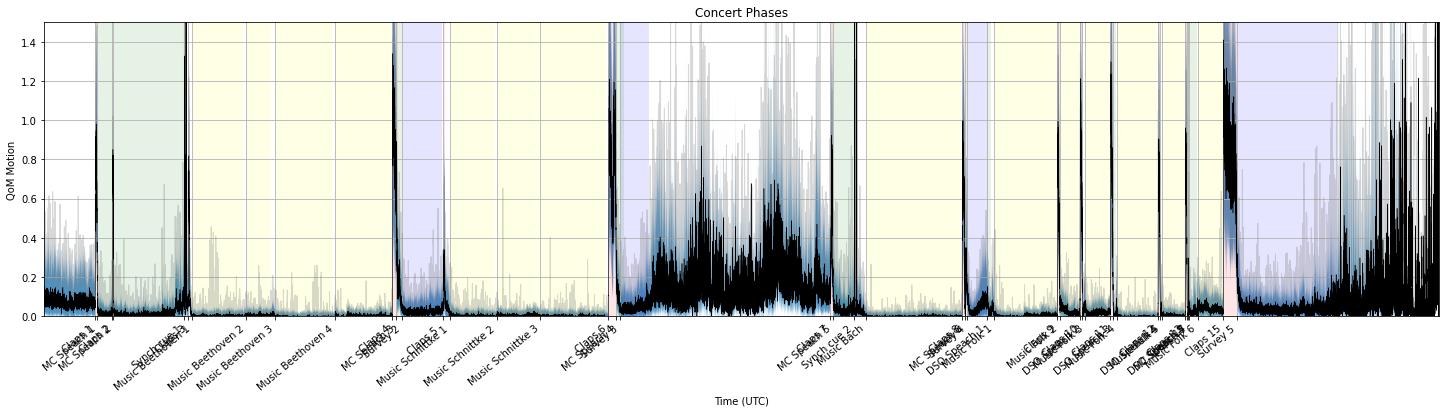

In [62]:
yrange = [0,1.5]
#aud_df.plot(ax=ax,linewidth=2,alpha=0.6,legend = False)

ax = aud_df.mean(axis=1).plot(color='grey',linewidth=1,alpha = 0.3,figsize=(25,6))
    
x = np.array(aud_df.index)
y1 = np.array(aud_df.quantile(q=0.25,axis = 1),dtype=np.float32)
y2 = np.array(aud_df.quantile(q=0.75,axis = 1),dtype=np.float32)
aud_df.median(axis=1).plot(color='k',linewidth=0.5)
ax.fill_between(x,y1,y2,alpha = 0.8)

ax.grid()
ax.set_title('Concert Phases')
ax.set_xlabel('Time (UTC)')
ax.set_ylabel('QoM Motion')
ax.set_ylim(yrange)
ax.set_xticks(concert_seg.Time_dt_Start)
ax.set_xticklabels(concert_seg['Event'],rotation=40,ha='right')

ax.margins(0)
for i in range(len(concert_seg)):
    r= concert_seg.iloc[i,:]
    ei = r.Time_dt_Start
    ej = r.Time_dt_End
    if r['Event_Type'].startswith('Applause'):
        ax.axvspan(ei, ej,yrange[0],yrange[1], facecolor='red', alpha=0.1)
    if r['Event_Type'].endswith('Music'):
        ax.axvspan(ei, ej,yrange[0],yrange[1], facecolor='yellow', alpha=0.1)
    if r['Event_Type'].endswith('Speach'):
        ax.axvspan(ei, ej,yrange[0],yrange[1], facecolor='green', alpha=0.1)
    if r['Event_Type'].startswith('Survey'):
        ax.axvspan(ei, ej,yrange[0],yrange[1], facecolor='blue', alpha=0.1)
    if r['Event_Type'].startswith('Synch'):
        ax.axvspan(ei, ej,yrange[0],yrange[1], facecolor='white', alpha=0.1)

plt.savefig('Concert_Motion_Full_Central.png',dpi = 300)
plt.show()

In [174]:
aud_df.median(axis=1).to_csv('Full_Mean.csv')

In [144]:
Main_concert_times['Event_Type'].value_counts()

Applause           17
Speech             16
Music              14
Survey              4
Synchronisation     2
End                 1
Name: Event_Type, dtype: int64

In [145]:
musics = Main_concert_times.loc[Main_concert_times['Event_Type'].str.contains('Music'),:]
Mus_DF = {}
Medians_df = pd.DataFrame(index = musics['Event'],columns = aud_df.columns)
mus_cat= pd.DataFrame(columns = aud_df.columns) 
for i,m in musics.iterrows():
    seg_start = m.name
    seg_end = Main_concert_times.loc[Main_concert_times['sequence'] == m['sequence']+1].index[0]
    seg_df = aud_df.loc[seg_start:seg_end]
    mus_cat = pd.concat([mus_cat,seg_df])
    Medians_df.loc[m['Event'],:] = seg_df.median()
    seg_df = seg_df.loc[:,seg_df.sum()>0]
    Mus_DF[m['Event']] = seg_df
    
    
len(Mus_DF)

14

In [146]:
Main_concert_times.loc[Main_concert_times['Event_Type'].str.contains('Music'),:]

,Time_s,Time_ms,Event,Event_Type,Time_Stream,Event_Duration,sequence
Datetime,,,,,,,
2021-10-26 17:49:03,57.40,57400,Beethoven 1,Music,1694.64,418.68,8
2021-10-26 17:56:02,476.08,476080,Beethoven 2,Music,2113.32,225.10,9
2021-10-26 17:59:47,701.18,701180,Beethoven 3,Music,2338.42,468.98,10
2021-10-26 18:07:36,1170.16,1170160,Beethoven 4,Music,2807.40,440.20,11
2021-10-26 18:22:20,2054.48,2054480,Schnittke 1,Music,3691.72,364.28,17
2021-10-26 18:28:25,2418.76,2418760,Schnittke 2,Music,4056.00,336.52,18
2021-10-26 18:34:01,2755.28,2755280,Schnittke 3,Music,4392.52,527.08,19
2021-10-26 19:16:00,5274.36,5274360,Bach,Music,6911.60,745.08,28
2021-10-26 19:32:37,6271.28,6271280,Folk 1,Music,7908.52,487.68,33


In [147]:
speeches = Main_concert_times.loc[Main_concert_times['Event_Type'].str.contains('Speech'),:]
Spe_DF = {}
Medians_df = pd.DataFrame(columns = aud_df.columns)
spe_cat= pd.DataFrame(columns = aud_df.columns) 
for i,m in speeches.iterrows():
    seg_start = m.name
    seg_end = Main_concert_times.loc[Main_concert_times['sequence'] == m['sequence']+1].index[0]
    seg_df = aud_df.loc[seg_start:seg_end]
    spe_cat = pd.concat([spe_cat,seg_df])
    Medians_df.loc[m['Event']+str(i),:] = seg_df.median()
    seg_df = seg_df.loc[:,seg_df.sum()>0]
    Spe_DF[m['Event']+str(i)] = seg_df
    
    
len(Spe_DF)

16

In [148]:
applauses = Main_concert_times.loc[Main_concert_times['Event_Type'].str.contains('Applause'),:]
App_DF = {}
Medians_df = pd.DataFrame(columns = aud_df.columns)
app_cat= pd.DataFrame(columns = aud_df.columns) 
for i,m in applauses.iterrows():
    seg_start = m.name
    seg_end = Main_concert_times.loc[Main_concert_times['sequence'] == m['sequence']+1].index[0]
    seg_df = aud_df.loc[seg_start:seg_end]
    app_cat = pd.concat([app_cat,seg_df])
    Medians_df.loc[m['Event']+str(i),:] = seg_df.median()
    seg_df = seg_df.loc[:,seg_df.sum()>0]
    App_DF[m['Event']+str(i)] = seg_df
    
    
len(App_DF)

17

<AxesSubplot:>

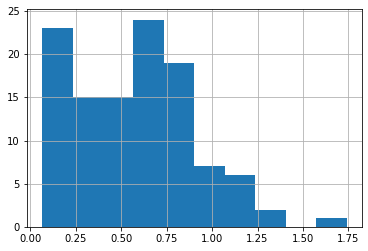

In [149]:
Medians_df.mean().hist()

<AxesSubplot:>

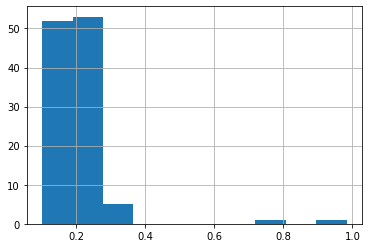

In [150]:
aud_df.mean().hist()

<AxesSubplot:>

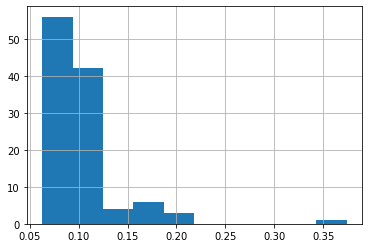

In [151]:
mus_cat.mean().hist()

<AxesSubplot:>

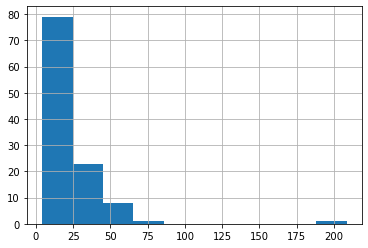

In [152]:
aud_df.max().hist()

<AxesSubplot:>

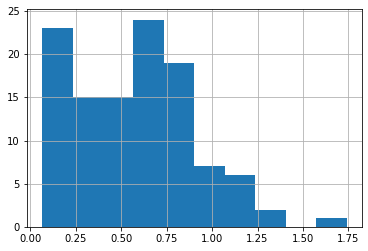

In [153]:
Medians_df.mean().hist()

In [154]:
list(Mus_DF)

['Beethoven 1',
 'Beethoven 2',
 'Beethoven 3',
 'Beethoven 4',
 'Schnittke 1',
 'Schnittke 2',
 'Schnittke 3',
 'Bach',
 'Folk 1',
 'Folk 2',
 'Folk 3',
 'Folk 4',
 'Folk 5',
 'Folk 6']

In [171]:
seg

,ADQ001,ADQ002,ADQ003,ADQ004,ADQ005,ADQ006,ADQ007,ADQ008,ADQ009,ADQ010,...,BEQ103,BEQ105,BEQ106,BEQ107,BEQ108,BEQ109,BEQ110,BEQ111,BEQ112,BEQ113
2021-10-26 19:58:21.099999992,2.113095,0.011846,0.000000,0.252306,NaN,0.000000,0.126089,0.280260,0.041234,0.082144,...,0.436885,0.074371,0.206619,0.024454,0.495474,0.061294,0.244636,0.071664,0.084818,0.074174
2021-10-26 19:58:21.199999992,1.925638,0.011846,0.072449,0.648604,NaN,0.000000,0.102404,0.057789,0.076052,0.148917,...,1.979584,0.086163,0.207107,0.055084,0.184958,0.130140,0.195284,0.070438,0.101908,0.057774
2021-10-26 19:58:21.299999992,0.782747,0.071689,0.060234,0.580963,NaN,0.100704,0.160036,0.344196,0.067305,0.089200,...,0.294539,0.086163,0.165117,0.071150,0.192647,0.122415,0.178927,0.099838,0.138352,0.056220
2021-10-26 19:58:21.399999992,1.327047,0.063378,0.089642,0.364178,NaN,0.159226,0.127857,0.370501,0.089244,0.170739,...,0.432657,0.105528,0.113023,0.134076,0.452612,0.064487,0.146771,0.059443,0.110710,0.025190
2021-10-26 19:58:21.499999992,1.868906,0.063378,0.071208,0.248191,NaN,0.100704,0.094784,0.167609,0.079836,0.139037,...,0.234030,0.074371,0.087700,0.142675,0.248622,0.067795,0.144024,0.146555,0.075772,0.054766
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-10-26 19:58:50.599999992,0.969682,0.162151,0.088116,0.433126,0.129233,1.067179,0.206775,4.010661,0.508397,0.176386,...,0.138989,0.000000,0.343984,0.040237,0.259010,0.027527,0.379293,0.076585,0.038190,0.083495
2021-10-26 19:58:50.699999992,1.098840,0.348622,0.063458,0.458349,0.166483,0.609469,0.048579,1.866478,0.411166,0.213290,...,0.191523,0.000000,0.286097,0.013068,0.197429,0.041316,0.735284,0.078901,0.034533,0.055117
2021-10-26 19:58:50.799999992,0.777343,0.103099,0.062831,0.214324,0.164522,0.128219,0.095465,1.238150,0.291291,0.294051,...,0.051587,0.051698,0.214529,0.113460,0.121983,0.034105,0.205127,0.037183,0.032219,0.069044
2021-10-26 19:58:50.899999992,0.654039,0.263320,0.088488,0.807166,0.150798,0.452032,0.244529,0.759080,0.076537,0.211816,...,0.053804,0.051698,0.058260,0.083398,0.098754,0.076005,0.185981,0.038288,0.072019,0.053275


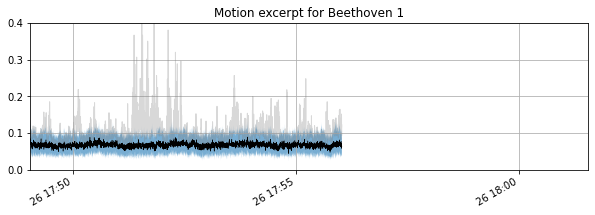

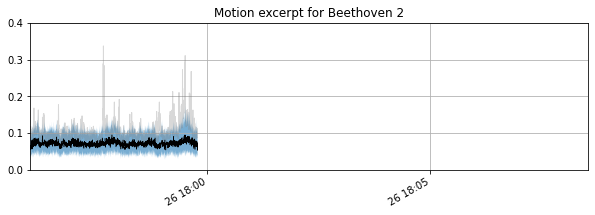

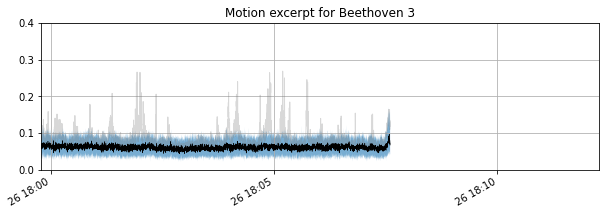

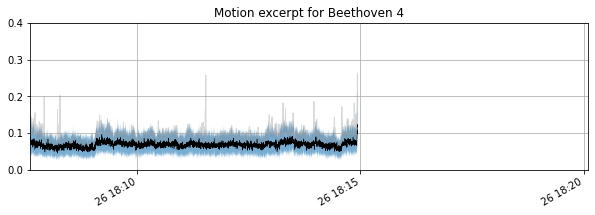

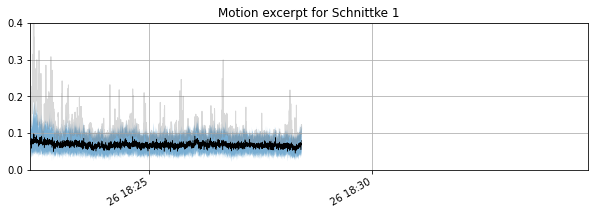

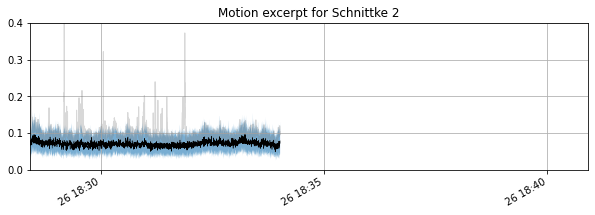

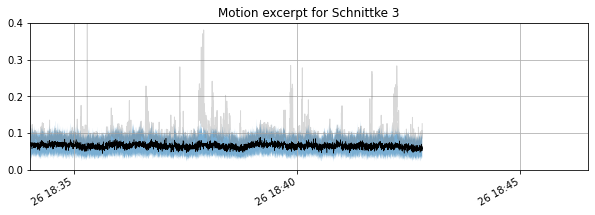

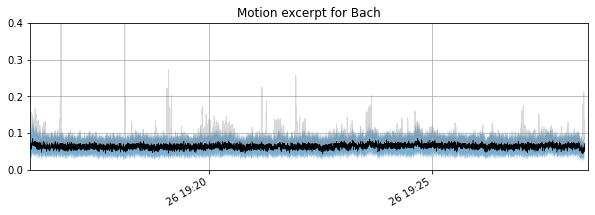

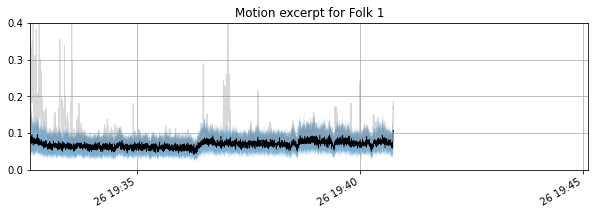

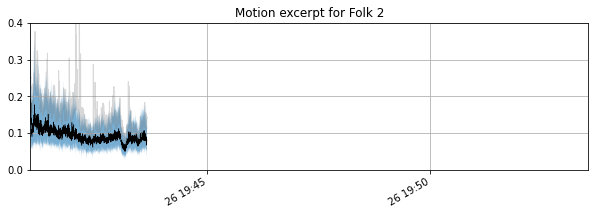

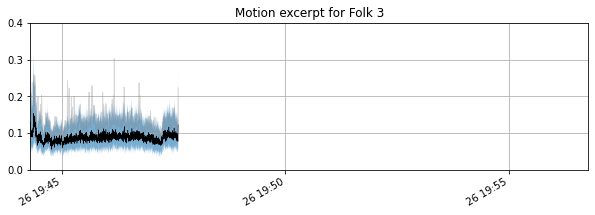

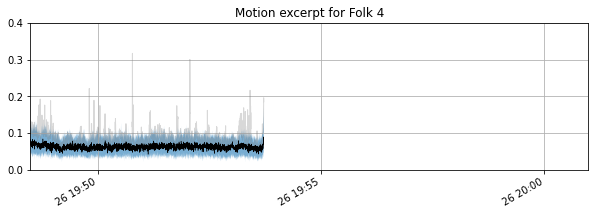

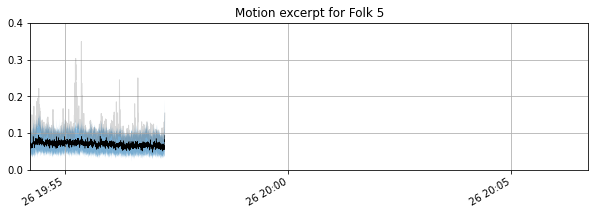

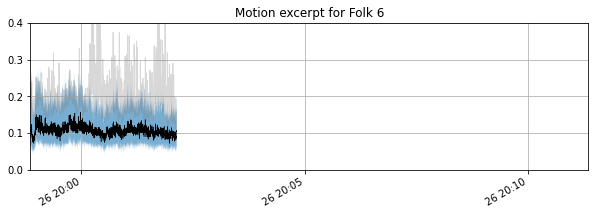

In [155]:
for k,seg in Mus_DF.items():
    #seg.plot(figsize=[8,3],legend=False,alpha = 0.2)
    ax = seg.mean(axis=1).plot(color='grey',linewidth=1,alpha = 0.3,figsize=[10,3])
    xrange = [seg.index[0], seg.index[0]+pd.Timedelta(seconds=750)]
    plt.ylim([0,0.4])
    plt.xlim(xrange)
    plt.title('Motion excerpt for ' + k)
    x = np.array(seg.index)
    y1 = np.array(seg.quantile(q=0.25,axis = 1),dtype=np.float32)
    y2 = np.array(seg.quantile(q=0.75,axis = 1),dtype=np.float32)
    seg.median(axis=1).plot(color='k',linewidth=0.5)
    ax.fill_between(x,y1,y2,alpha = 0.6)
    plt.grid()
    #plt.savefig('plots/Sample_pair.png',dpi=400)
    plt.show()


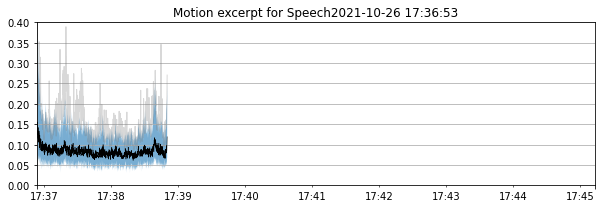

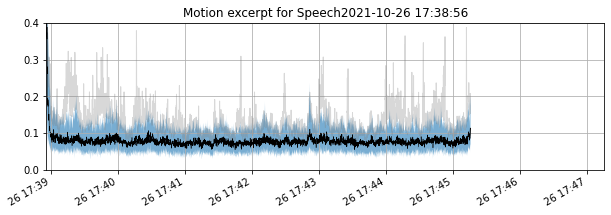

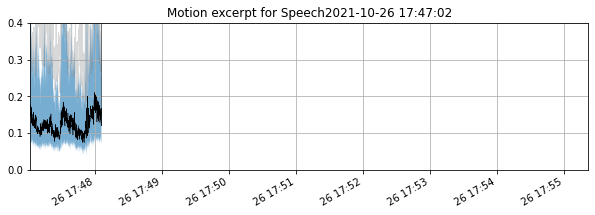

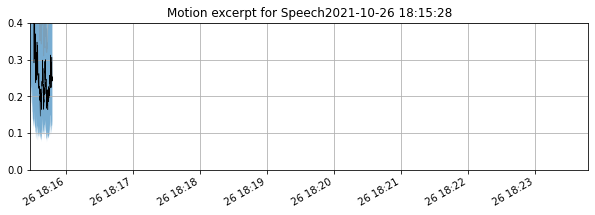

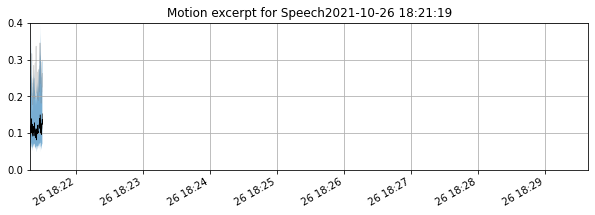

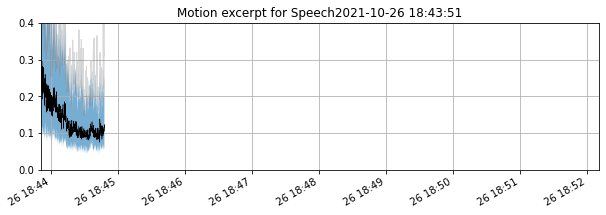

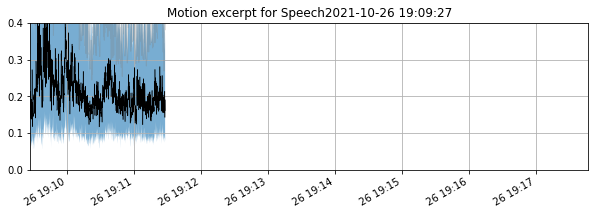

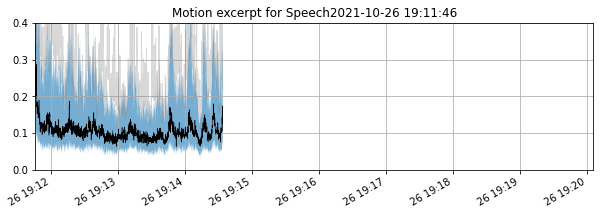

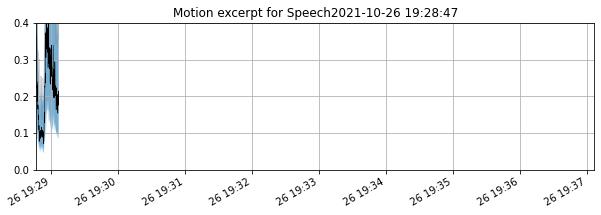

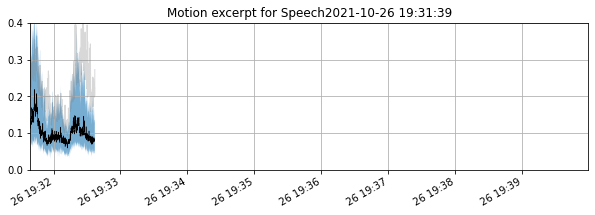

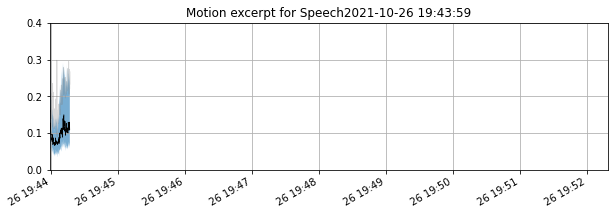

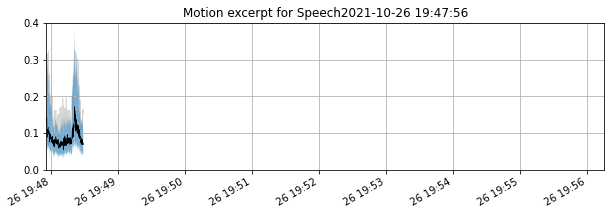

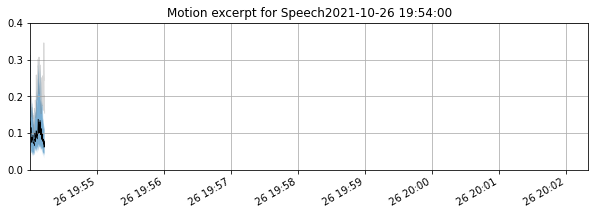

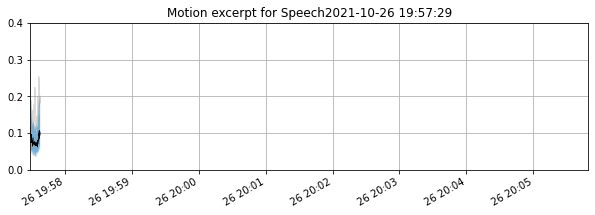

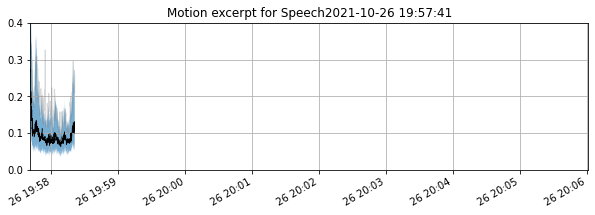

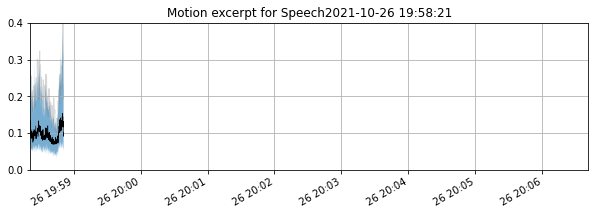

In [156]:

for k,seg in Spe_DF.items():
    #seg.plot(figsize=[8,3],legend=False,alpha = 0.2)
    ax = seg.mean(axis=1).plot(color='grey',linewidth=1,alpha = 0.3,figsize=[10,3])
    x = np.array(seg.index)
    y1 = np.array(seg.quantile(q=0.25,axis = 1),dtype=np.float32)
    y2 = np.array(seg.quantile(q=0.75,axis = 1),dtype=np.float32)
    seg.median(axis=1).plot(color='k',linewidth=0.5)
    ax.fill_between(x,y1,y2,alpha = 0.6)
    plt.grid()
    
    xrange = [seg.index[0], seg.index[0]+pd.Timedelta(seconds=500)]
    plt.ylim([0,0.4])
    plt.xlim(xrange)
    plt.title('Motion excerpt for ' + k)
    #plt.savefig('plots/Sample_pair.png',dpi=400)
    plt.show()
